## Reformat PS table

In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyvo.dal import TAPService
from pyia import GaiaData

import gala.coordinates as gc
import scipy.stats


In [2]:
plt.style.use('notebook')

In [3]:
def reformat_lsdoutput(name):
    tps = Table(fits.getdata('../data/{}.fits'.format(name)))
    t = tps.copy()
    
    # remove extra columns
    allkey = tps.colnames
    pskeys = [x for x in allkey if 'ucal' in x]
    t.remove_columns(pskeys)
    
    # convert fluxes to magnitudes
    median = -2.5*np.log10(np.clip(tps['ucal_fluxqz.median'],1e-12,np.inf))
    err = np.sqrt((1.0857*(tps['ucal_fluxqz.err']/median))**2 + 0.01**2)

    # get reddening
    #reddening = sfd.reddening(c, survey='PS1', filters='grizy')
    
    bands = ['g', 'r', 'i', 'z', 'y']
    for e,b in enumerate(bands):
        t[b] = median[:,e]*u.mag
        t['{}_error'.format(b)] = err[:,e]*u.mag
    
    t.write('../data/{}_reformat.fits'.format(name), overwrite=True)

In [4]:
for b1 in range(10,70,10):
    name = 'gd1_ps_{:02.0f}_{:02.0f}'.format(b1, b1+10)
    print(name)
    reformat_lsdoutput(name)

gd1_ps_10_20
gd1_ps_20_30
gd1_ps_30_40
gd1_ps_40_50
gd1_ps_50_60
gd1_ps_60_70


## CMD

In [5]:
t1 = Table(fits.getdata('../data/gd1_ps_10_20_reformat.fits'))
t2 = Table(fits.getdata('../data/gd1_ps_20_30_reformat.fits'))
t3 = Table(fits.getdata('../data/gd1_ps_30_40_reformat.fits'))
t4 = Table(fits.getdata('../data/gd1_ps_40_50_reformat.fits'))
t5 = Table(fits.getdata('../data/gd1_ps_50_60_reformat.fits'))
t6 = Table(fits.getdata('../data/gd1_ps_60_70_reformat.fits'))
t = vstack((t1, t2, t3, t4, t5, t6))

In [6]:
del t1
del t2
del t3
del t4
del t5
del t6

In [7]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [8]:
def gd1_dist(phi1):
    # 0, 10
    # -60, 7
    m = (10-7) / (60)
    return (m*phi1.wrap_at(180*u.deg).value + 10) * u.kpc

In [9]:
gd1_c = c.transform_to(gc.GD1)
gd1_c_noreflex = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=gd1_c.phi1, phi2=gd1_c.phi2,
                    distance=gd1_dist(gd1_c.phi1),
                    pm_phi1_cosphi2=gd1_c.pm_phi1_cosphi2,
                    pm_phi2=gd1_c.pm_phi2,
                    radial_velocity=[0]*len(gd1_c)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
# gd1_c_nosunv = coord.Galactic(rep).transform_to(gc.GD1)
gd1_c = coord.Galactic(rep).transform_to(gc.GD1)

In [10]:
pm_mask = ((gd1_c.pm_phi1_cosphi2 < -5*u.mas/u.yr) & (gd1_c.pm_phi1_cosphi2 > -10*u.mas/u.yr) & 
           (gd1_c.pm_phi2 < 1*u.mas/u.yr) & (gd1_c.pm_phi2 > -2*u.mas/u.yr) & 
           (g.bp_rp < 1.5*u.mag) & (g.bp_rp > 0*u.mag))

# pm_left = np.sqrt((gd1_c.pm_phi1_cosphi2 + 7.6*u.mas/u.yr)**2 + (gd1_c.pm_phi2 + 0.5*u.mas/u.yr)**2)<0.6*u.mas/u.yr
# pm_right = np.sqrt((gd1_c.pm_phi1_cosphi2 + 6*u.mas/u.yr)**2 + (gd1_c.pm_phi2 + 0.*u.mas/u.yr)**2)<0.4*u.mas/u.yr
# pm_mask = pm_left | pm_right

/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


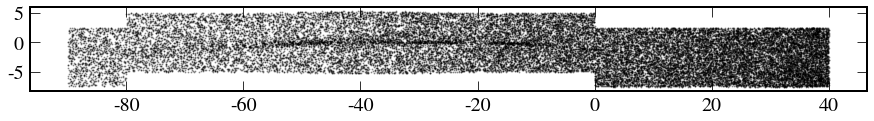

In [11]:
plt.figure(figsize=(15,10))
plt.plot(gd1_c.phi1[pm_mask].wrap_at(180*u.deg), gd1_c.phi2[pm_mask], 'ko', ms=1, alpha=0.3)
plt.gca().set_aspect('equal')

In [12]:
phi_mask_stream = np.abs(gd1_c.phi2)<1*u.deg
phi_mask_off = ((gd1_c.phi2<-2*u.deg) & (gd1_c.phi2>-3*u.deg)) | ((gd1_c.phi2<3*u.deg) & (gd1_c.phi2>2*u.deg))

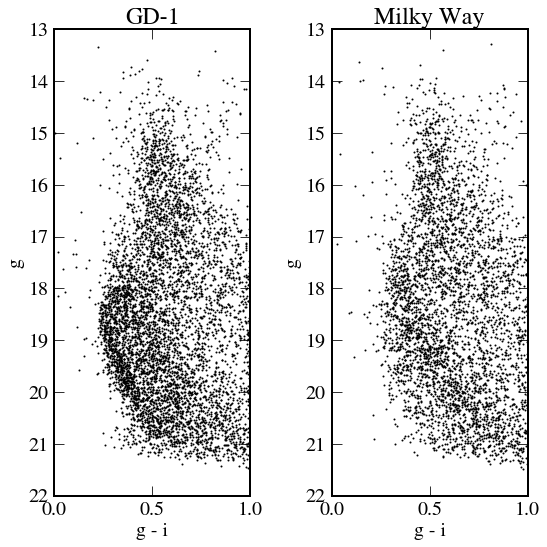

In [41]:
fig, ax = plt.subplots(1,2,figsize=(8,8))

plt.sca(ax[0])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=1)

plt.xlim(0,1)
plt.ylim(22, 13)
plt.xlabel('g - i')
plt.ylabel('g')
plt.title('GD-1')

plt.sca(ax[1])
plt.plot(g.g[phi_mask_off & pm_mask] - g.i[phi_mask_off & pm_mask], g.g[phi_mask_off & pm_mask], 
         'ko', ms=1)

plt.xlim(0.,1.)
plt.ylim(22, 13)
plt.xlabel('g - i')
plt.ylabel('g')
plt.title('Milky Way')

plt.tight_layout()

In [14]:
iso = Table.read('../data/gd1-isochrone_ps.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

In [15]:
phi1_spur = coord.Angle(325*u.deg)
dm = 5*np.log10((gd1_dist(phi1_spur).to(u.pc)).value)-5

In [16]:
# main sequence + rgb
# notice by-hand reddening of the isochrone ... will remove once manage to install sfd w anaconda
i_gr = iso['PS_g']-iso['PS_r']+0.07
i_g = iso['PS_g']+dm+0.2

i_left = i_gr - 0.4*(i_g/28)**5
i_right = i_gr + 0.5*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.5) & (poly[:,1]>18.)
poly_main = poly[ind]

In [17]:
# isochrone for the contaminant
i2_gr = iso['PS_g']-iso['PS_r']+0.12
i2_g = iso['PS_g']+dm-0.7

i2_left = i2_gr - 0.4*(i2_g/28)**5
i2_right = i2_gr + 0.5*(i2_g/28)**5

poly2 = np.hstack([np.array([i2_left, i2_g]), np.array([i2_right[::-1], i2_g[::-1]])]).T
ind2 = (poly2[:,1]<21.5) & (poly2[:,1]>17.)
poly2_main = poly2[ind2]

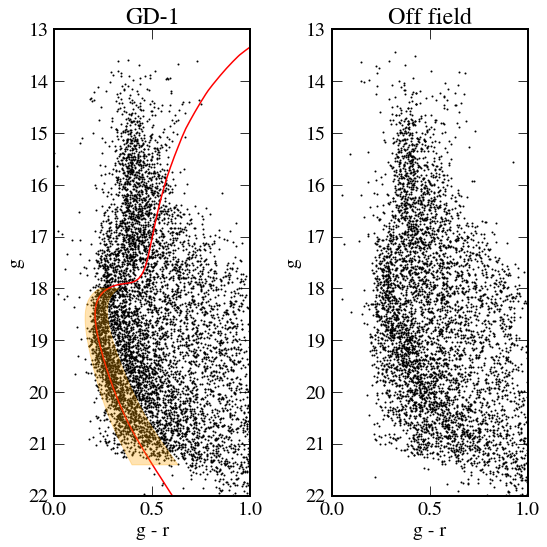

In [18]:
fig, ax = plt.subplots(1,2,figsize=(8,8))

plt.sca(ax[0])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.r[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=1)

plt.plot(i_gr, i_g, 'r-')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2)
plt.gca().add_artist(pm)

plt.xlim(0,1)
plt.ylim(22, 13)
plt.xlabel('g - r')
plt.ylabel('g')
plt.title('GD-1')

plt.sca(ax[1])
plt.plot(g.g[phi_mask_off & pm_mask] - g.r[phi_mask_off & pm_mask], g.g[phi_mask_off & pm_mask], 
         'ko', ms=1)

# plt.plot(i2_gr, i2_g, 'b-')
# pm2 = mpl.patches.Polygon(poly2_main, color='skyblue', alpha=0.3, zorder=2)
# plt.gca().add_artist(pm2)

plt.xlim(0.,1.)
plt.ylim(22, 13)
plt.xlabel('g - r')
plt.ylabel('g')
plt.title('Off field')

plt.tight_layout()
plt.savefig('../plots/cmd.pdf')

In [19]:
points = np.array([g.g - g.r, g.g]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -9*u.mas/u.yr
pm1_max = -4.5*u.mas/u.yr
pm2_min = -1.7*u.mas/u.yr
pm2_max = 1.*u.mas/u.yr
pm_mask = ((gd1_c.pm_phi1_cosphi2 < pm1_max) & (gd1_c.pm_phi1_cosphi2 > pm1_min) & 
           (gd1_c.pm_phi2 < pm2_max) & (gd1_c.pm_phi2 > pm2_min))

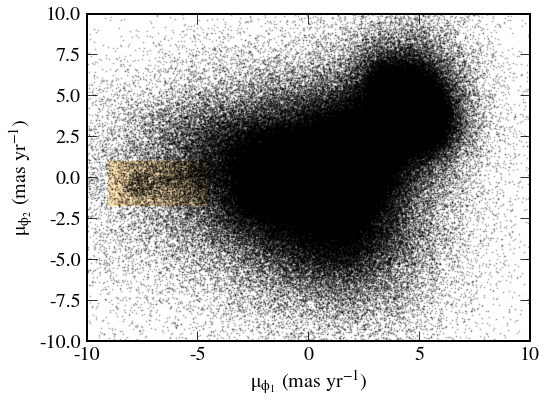

In [20]:
rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.plot(gd1_c.pm_phi1_cosphi2[cmd_mask].to(u.mas/u.yr), 
         gd1_c.pm_phi2[cmd_mask].to(u.mas/u.yr), 
         'ko', ms=1, alpha=0.2, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ (mas yr$^{-1}$)')
plt.ylabel('$\mu_{\phi_2}$ (mas yr$^{-1}$)')

plt.tight_layout()
plt.savefig('../plots/pm.pdf', dpi=150)

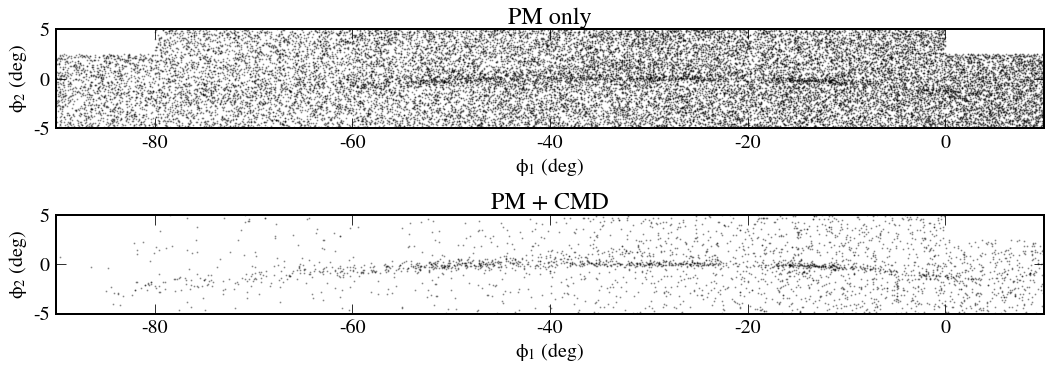

In [21]:
fig, ax = plt.subplots(2,1, figsize=(15,5.5))

plt.sca(ax[0])
plt.plot(gd1_c.phi1[pm_mask].wrap_at(180*u.deg), gd1_c.phi2[pm_mask], 'ko', ms=1, alpha=0.3, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.title('PM only')

plt.xlim(-90,10)
plt.ylim(-5,5)

plt.sca(ax[1])
plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg), 
         gd1_c.phi2[pm_mask & cmd_mask], 'ko', ms=1, alpha=0.3, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.title('PM + CMD')
plt.xlim(-90,10)
plt.ylim(-5,5)

plt.tight_layout()
plt.savefig('../plots/map_orig_cmd.pdf', dpi=150)

## Spur

In [22]:
wangle = 180*u.deg

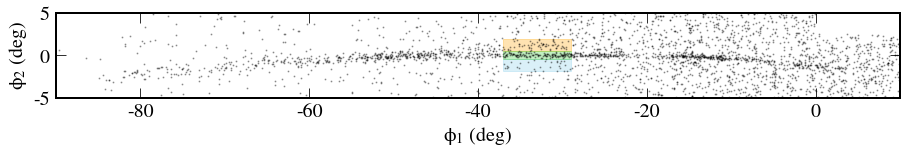

In [23]:
bspur1_min = coord.Angle(323*u.deg).wrap_at(wangle)
bspur1_max = coord.Angle(331*u.deg).wrap_at(wangle)
bspur2_min = 0.5*u.deg
bspur2_max = 2*u.deg

rect_spur_xy = [bspur1_min.to(u.deg).value, bspur2_min.to(u.deg).value]
rect_spur_w = bspur1_max.to(u.deg).value - bspur1_min.to(u.deg).value
rect_spur_h = bspur2_max.to(u.deg).value - bspur2_min.to(u.deg).value

boff1_min = coord.Angle(323*u.deg).wrap_at(wangle)
boff1_max = coord.Angle(331*u.deg).wrap_at(wangle)
boff2_min = -1.9*u.deg
boff2_max = -0.4*u.deg

rect_off_xy = [boff1_min.to(u.deg).value, boff2_min.to(u.deg).value]
rect_off_w = boff1_max.to(u.deg).value - boff1_min.to(u.deg).value
rect_off_h = boff2_max.to(u.deg).value - boff2_min.to(u.deg).value

bstream1_min = coord.Angle(323*u.deg).wrap_at(wangle)
bstream1_max = coord.Angle(331*u.deg).wrap_at(wangle)
bstream2_min = -0.4*u.deg
bstream2_max = 0.5*u.deg

rect_stream_xy = [bstream1_min.to(u.deg).value, bstream2_min.to(u.deg).value]
rect_stream_w = bstream1_max.to(u.deg).value - bstream1_min.to(u.deg).value
rect_stream_h = bstream2_max.to(u.deg).value - bstream2_min.to(u.deg).value

plt.figure(figsize=(13,6))
plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(wangle), gd1_c.phi2[pm_mask & cmd_mask], 
         'ko', ms=1, alpha=0.3, rasterized=True)
plt.gca().set_aspect('equal')

pr_spur = mpl.patches.Rectangle(rect_spur_xy, rect_spur_w, rect_spur_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr_spur)

pr_off = mpl.patches.Rectangle(rect_off_xy, rect_off_w, rect_off_h, color='skyblue', alpha=0.3)
plt.gca().add_artist(pr_off)

pr_stream = mpl.patches.Rectangle(rect_stream_xy, rect_stream_w, rect_stream_h, color='limegreen', alpha=0.3)
plt.gca().add_artist(pr_stream)

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-90,10)
plt.ylim(-5,5)

plt.tight_layout()

In [27]:
spur_mask = ((gd1_c.phi1.wrap_at(wangle)<bspur1_max) & (gd1_c.phi1.wrap_at(wangle)>bspur1_min) &
            (gd1_c.phi2<bspur2_max) & (gd1_c.phi2>bspur2_min)) 
off_mask = ((gd1_c.phi1.wrap_at(wangle)<boff1_max) & (gd1_c.phi1.wrap_at(wangle)>boff1_min) &
            (gd1_c.phi2<boff2_max) & (gd1_c.phi2>boff2_min))
stream_mask = ((gd1_c.phi1.wrap_at(wangle)<bstream1_max) & (gd1_c.phi1.wrap_at(wangle)>bstream1_min) &
            (gd1_c.phi2<bstream2_max) & (gd1_c.phi2>bstream2_min))

pm_generous_mask = ((gd1_c.pm_phi1_cosphi2 < -5*u.mas/u.yr) & (gd1_c.pm_phi1_cosphi2 > -10*u.mas/u.yr) & 
           (gd1_c.pm_phi2 < 1*u.mas/u.yr) & (gd1_c.pm_phi2 > -2*u.mas/u.yr))

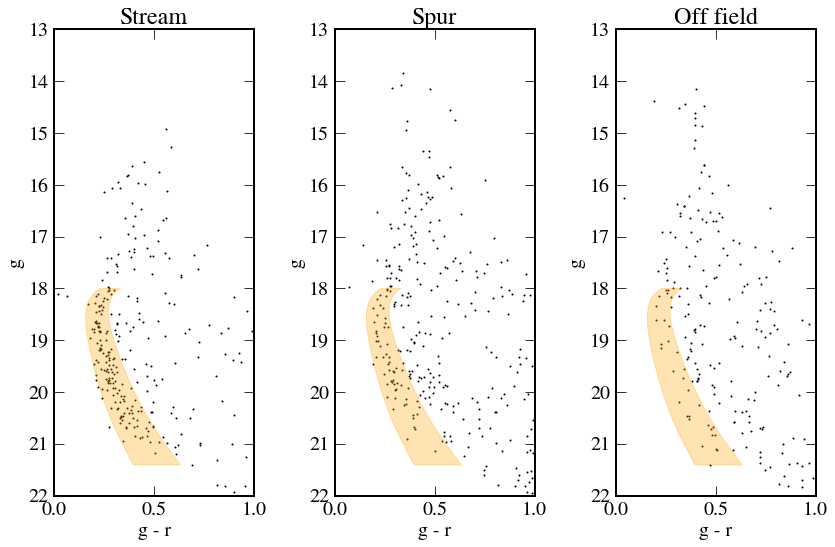

In [28]:
fig, ax = plt.subplots(1,3,figsize=(12,8))

plt.sca(ax[0])
plt.plot(g.g[stream_mask & pm_generous_mask] - g.r[stream_mask & pm_generous_mask], g.g[stream_mask & pm_generous_mask], 
         'ko', ms=1)

# plt.plot(i_gr, i_g, 'r-')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2)
plt.gca().add_artist(pm)

plt.xlim(0,1)
plt.ylim(22, 13)
plt.xlabel('g - r')
plt.ylabel('g')
plt.title('Stream')

plt.sca(ax[1])
plt.plot(g.g[spur_mask & pm_generous_mask] - g.r[spur_mask & pm_generous_mask], g.g[spur_mask & pm_generous_mask], 
         'ko', ms=1)

# plt.plot(i_gr, i_g, 'r-')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2)
plt.gca().add_artist(pm)

plt.xlim(0,1)
plt.ylim(22, 13)
plt.xlabel('g - r')
plt.ylabel('g')
plt.title('Spur')

plt.sca(ax[2])
plt.plot(g.g[off_mask & pm_generous_mask] - g.r[off_mask & pm_generous_mask], g.g[off_mask & pm_generous_mask], 
         'ko', ms=1)

pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2)
plt.gca().add_artist(pm)

plt.xlim(0.,1.)
plt.ylim(22, 13)
plt.xlabel('g - r')
plt.ylabel('g')
plt.title('Off field')

plt.tight_layout()

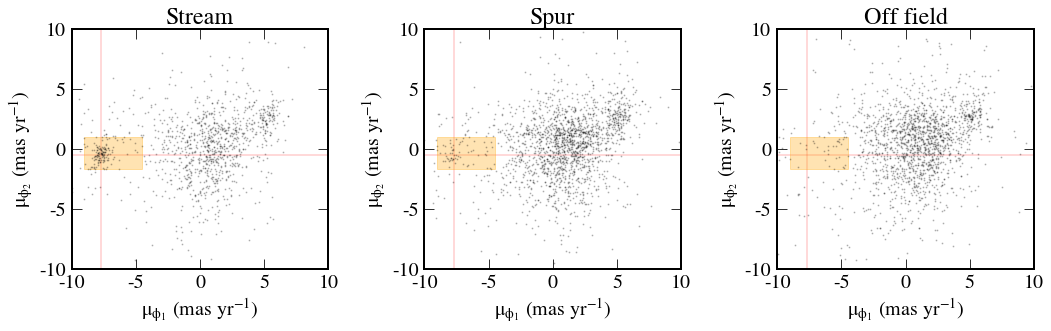

In [29]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

plt.sca(ax[0])
plt.plot(gd1_c.pm_phi1_cosphi2[cmd_mask & stream_mask].to(u.mas/u.yr), 
         gd1_c.pm_phi2[cmd_mask & stream_mask].to(u.mas/u.yr), 
         'ko', ms=1, alpha=0.2, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

mu_stream = np.array([-7.7, -0.5])*u.mas/u.yr
plt.axhline(mu_stream[1].value, color='r', alpha=0.2, zorder=0)
plt.axvline(mu_stream[0].value, color='r', alpha=0.2, zorder=0)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ (mas yr$^{-1}$)')
plt.ylabel('$\mu_{\phi_2}$ (mas yr$^{-1}$)')
plt.title('Stream')

plt.sca(ax[1])
plt.plot(gd1_c.pm_phi1_cosphi2[cmd_mask & spur_mask].to(u.mas/u.yr), 
         gd1_c.pm_phi2[cmd_mask & spur_mask].to(u.mas/u.yr), 
         'ko', ms=1, alpha=0.2, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.axhline(mu_stream[1].value, color='r', alpha=0.2, zorder=0)
plt.axvline(mu_stream[0].value, color='r', alpha=0.2, zorder=0)

mu_spur = np.array([-8, -0.75])*u.mas/u.yr
# plt.plot(mu_spur[0], mu_spur[1], 'ro', ms=12, alpha=0.2, zorder=0)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ (mas yr$^{-1}$)')
plt.ylabel('$\mu_{\phi_2}$ (mas yr$^{-1}$)')
plt.title('Spur')

plt.sca(ax[2])
plt.plot(gd1_c.pm_phi1_cosphi2[cmd_mask & off_mask].to(u.mas/u.yr), 
         gd1_c.pm_phi2[cmd_mask & off_mask].to(u.mas/u.yr), 
         'ko', ms=1, alpha=0.2, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.axhline(mu_stream[1].value, color='r', alpha=0.2, zorder=0)
plt.axvline(mu_stream[0].value, color='r', alpha=0.2, zorder=0)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ (mas yr$^{-1}$)')
plt.ylabel('$\mu_{\phi_2}$ (mas yr$^{-1}$)')
plt.title('Off field')

plt.tight_layout()

## Stream track

In [30]:
phi2_wide_mask = np.abs(gd1_c.phi2)<4*u.deg

dphi = 3
bins_phi1 = np.arange(-80,5,dphi)
cen_phi1 = 0.5*(bins_phi1[1:]+bins_phi1[:-1])

# median track
phi2_median, be, bn = scipy.stats.binned_statistic((gd1_c.phi1[pm_mask & cmd_mask]).wrap_at(wangle), 
                                                   gd1_c.phi2[pm_mask & cmd_mask], statistic='median', bins=bins_phi1)
phi1_sum, be = np.histogram((gd1_c.phi1[pm_mask & cmd_mask]).wrap_at(wangle), bins=bins_phi1)
phi2_median_err = np.abs(phi2_median)/np.sqrt(phi1_sum)

In [31]:
deg = 2
ptrack = np.polyfit(cen_phi1, phi2_median, deg, w=np.sqrt(phi1_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-80,10,100)
phi2_ = polytrack(phi1_)
np.savez('../data/gd1_polytrack', p=ptrack)

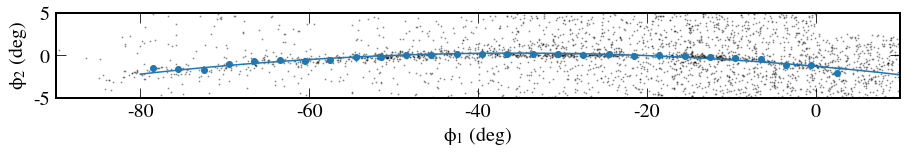

In [32]:
plt.figure(figsize=(13,6))
plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(wangle), gd1_c.phi2[pm_mask & cmd_mask], 
         'ko', ms=1, alpha=0.3, rasterized=True)
plt.gca().set_aspect('equal')

plt.errorbar(cen_phi1, phi2_median, yerr=phi2_median_err, fmt='o', color='tab:blue')
plt.plot(phi1_, phi2_, '-', color='tab:blue')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-90,10)
plt.ylim(-5,5)

plt.tight_layout()

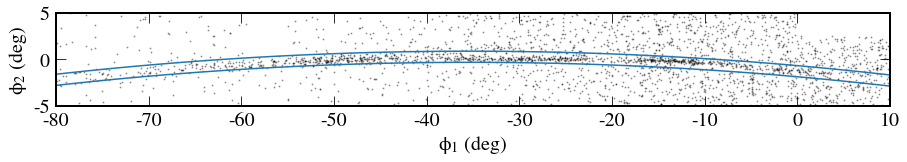

In [33]:
delta_phi2 = 0.6
plt.figure(figsize=(13,6))
plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg), gd1_c.phi2[pm_mask & cmd_mask], 
         'ko', ms=1, alpha=0.3, rasterized=True)
plt.gca().set_aspect('equal')

plt.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
plt.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-80,10)
plt.ylim(-5,5)

plt.tight_layout()

In [34]:
def mad(x):
    """Median absolute deviation"""
    return 1.5*np.median(np.abs(np.median(x)-x))

In [47]:
delta_phi = 1
window = 10
off_phi2 = 2

bins_phi1 = np.arange(-85-0.5*window, 10+0.5*window, delta_phi)
Nbins = np.size(bins_phi1)

n = np.zeros(Nbins)
n_back = np.zeros(Nbins)
w = np.zeros(Nbins)*u.deg
rmed_phi2 = np.zeros(Nbins)*u.deg
rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

phi2_poly = polytrack(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg))

for i in range(Nbins):
    sel_bin = ((gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg).to(u.deg).value>bins_phi1[i]-0.5*window) & 
                 (gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg).to(u.deg).value<=bins_phi1[i]+0.5*window))
    sel_stream = (np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly)<delta_phi2)
    sel_back = ((np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
                (np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
    selection = sel_bin & sel_stream
    
    n[i] = np.sum(selection)
    n_back[i] = np.sum(sel_bin & sel_back) * 0.5
    
    rmed_phi2[i] = np.nanmedian(gd1_c.phi2[pm_mask & cmd_mask][selection])
    w[i] = mad(gd1_c.phi2[pm_mask & cmd_mask][selection])
    
    rmed_pmphi1[i] = np.nanmedian(gd1_c_noreflex.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    rmed_pmphi1_err[i] = mad(gd1_c.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    
    rmed_pmphi2[i] = np.nanmedian(gd1_c_noreflex.pm_phi2[pm_mask & cmd_mask][selection])
    rmed_pmphi2_err[i] = mad(gd1_c_noreflex.pm_phi2[pm_mask & cmd_mask][selection])

/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


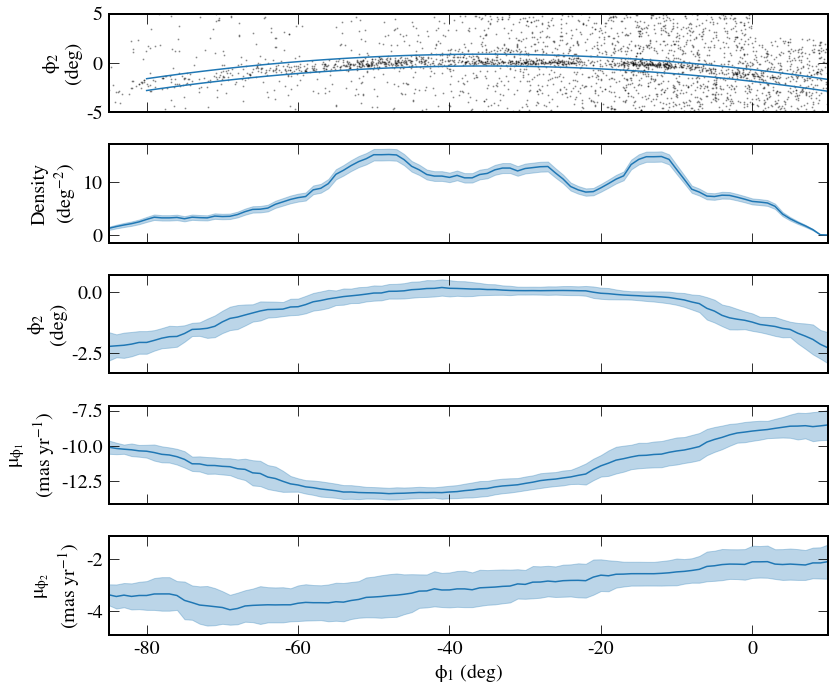

In [48]:
fig, ax = plt.subplots(5,1,figsize=(12,10), sharex=True)

plt.sca(ax[0])
plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg), gd1_c.phi2[pm_mask & cmd_mask], 
         'ko', ms=1, alpha=0.3, rasterized=True)
# plt.gca().set_aspect('equal')

plt.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
plt.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')

plt.ylabel('$\phi_2$\n(deg)')
plt.ylim(-5,5)

plt.sca(ax[1])
density = (n-n_back)/(2*delta_phi2*window)
plt.plot(bins_phi1, density, '-')
plt.fill_between(bins_phi1, density*(1-1/np.sqrt(n)), density*(1+1/np.sqrt(n)), color='tab:blue', alpha=0.3)
plt.ylabel('Density\n(deg$^{-2}$)')

plt.sca(ax[2])
plt.plot(bins_phi1, rmed_phi2, '-')
plt.fill_between(bins_phi1, rmed_phi2-w, rmed_phi2+w, color='tab:blue', alpha=0.3)
plt.ylabel('$\phi_2$\n(deg)')

plt.sca(ax[3])
plt.plot(bins_phi1, rmed_pmphi1, '-')
plt.fill_between(bins_phi1, rmed_pmphi1-rmed_pmphi1_err, rmed_pmphi1+rmed_pmphi1_err, color='tab:blue', alpha=0.3)
plt.ylabel('$\mu_{\phi_1}$\n(mas yr$^{-1}$)')

plt.sca(ax[4])
plt.plot(bins_phi1, rmed_pmphi2, '-')
plt.fill_between(bins_phi1, rmed_pmphi2-rmed_pmphi2_err, rmed_pmphi2+rmed_pmphi2_err, color='tab:blue', alpha=0.3)
plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\mu_{\phi_2}$\n(mas yr$^{-1}$)')
plt.xlim(-85,10)

plt.tight_layout()
plt.savefig('../plots/track_observables.pdf')

In [46]:
# output table w track observables
ttrack = Table([bins_phi1, n, n_back, density, rmed_phi2, w, rmed_pmphi1, rmed_pmphi1_err, rmed_pmphi2, rmed_pmphi2_err],
              names=('phi1', 'n', 'n_back', 'density', 'phi2', 'w', 'pm_phi1_cosphi2', 'pm_phi1_cosphi2_error', 
                     'pm_phi2', 'pm_phi2_error'))
ttrack.write('../data/track.fits', overwrite=True)

## Contaminant

In [223]:
path2_main = mpl.path.Path(poly2_main)
cmd2_mask = path2_main.contains_points(points)

pm1_min2 = -8.5*u.mas/u.yr
pm1_max2 = -5*u.mas/u.yr
pm2_min2 = -1*u.mas/u.yr
pm2_max2 = 0.5*u.mas/u.yr
pm2_mask = ((gd1_c.pm_phi1_cosphi2 < pm1_max2) & (gd1_c.pm_phi1_cosphi2 > pm1_min2) & 
           (gd1_c.pm_phi2 < pm2_max2) & (gd1_c.pm_phi2 > pm2_min2))

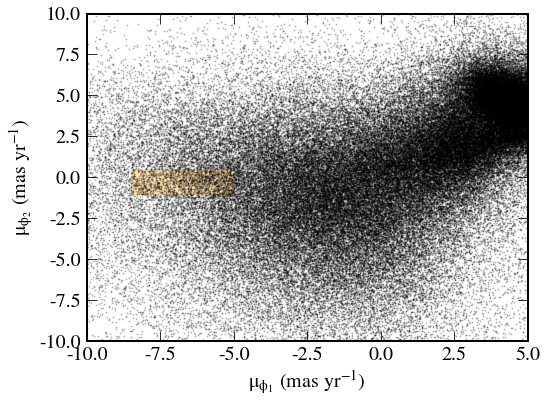

In [224]:
rect_xy2 = [pm1_min2.to(u.mas/u.yr).value, pm2_min2.to(u.mas/u.yr).value]
rect_w2 = pm1_max2.to(u.mas/u.yr).value - pm1_min2.to(u.mas/u.yr).value
rect_h2 = pm2_max2.to(u.mas/u.yr).value - pm2_min2.to(u.mas/u.yr).value

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.plot(gd1_c.pm_phi1_cosphi2[cmd2_mask].to(u.mas/u.yr), 
         gd1_c.pm_phi2[cmd2_mask].to(u.mas/u.yr), 
         'ko', ms=1, alpha=0.2, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy2, rect_w2, rect_h2, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,5)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ (mas yr$^{-1}$)')
plt.ylabel('$\mu_{\phi_2}$ (mas yr$^{-1}$)')

plt.tight_layout()

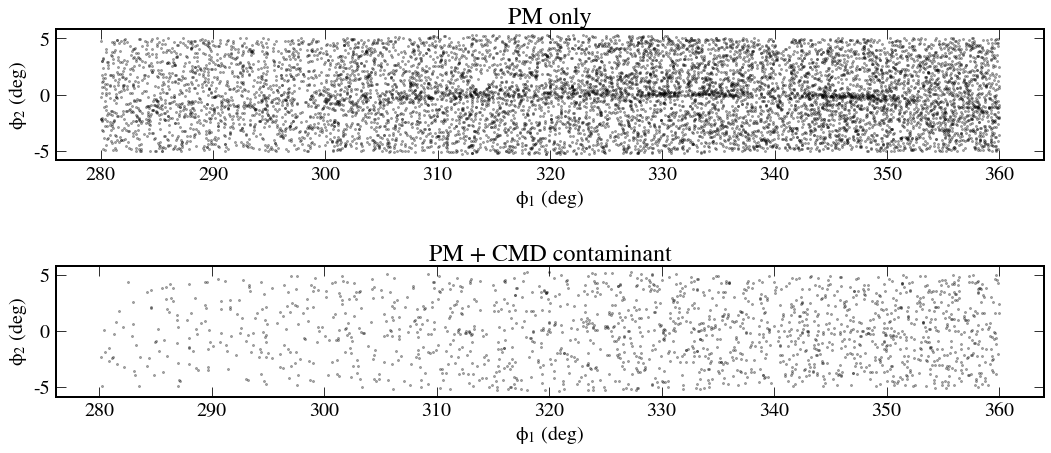

In [226]:
fig, ax = plt.subplots(2,1, figsize=(15,7))

plt.sca(ax[0])
plt.plot(gd1_c.phi1[pm2_mask], gd1_c.phi2[pm2_mask], 'ko', ms=2, alpha=0.3, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.title('PM only')

plt.sca(ax[1])
plt.plot(gd1_c.phi1[pm2_mask & cmd2_mask], gd1_c.phi2[pm2_mask & cmd2_mask], 'ko', ms=2, alpha=0.3, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.title('PM + CMD contaminant')

plt.tight_layout()